In [ ]:
# Complete Fast R-CNN for Object Detection on Tiny Object Dataset
# Improved implementation using ROI Pooling and single CNN pass architecture
# Fixed and restructured implementation for Google Colab

# Step 1: Install dependencies and download dataset
!pip install kagglehub opencv-contrib-python --quiet

In [ ]:
import kagglehub
import os
import json
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [ ]:
# Download dataset
path = kagglehub.dataset_download("kailaspsudheer/tiny-object-detection")
print("Path to dataset files:", path)

100%|██████████| 179M/179M [00:01<00:00, 154MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kailaspsudheer/tiny-object-detection/versions/4


In [ ]:
!mkdir kaggle

!ls '/kaggle/input/tiny-object-detection/SkyFusion'

ls: cannot access '/kaggle/input/tiny-object-detection/SkyFusion': No such file or directory


In [ ]:
!cp -R /root/.cache/kagglehub/datasets/kailaspsudheer/tiny-object-detection/versions/4/* /content/kaggle/tiny-object-detection/

In [ ]:
# Check dataset structure
base_path = "/content/kaggle/tiny-object-detection/"

# Dataset paths
train_image_dir = os.path.join(base_path, "train")
train_ann_file = os.path.join(base_path, "train/_annotations.coco.json")
valid_image_dir = os.path.join(base_path, "valid")
valid_ann_file = os.path.join(base_path, "valid/_annotations.coco.json")
test_image_dir = os.path.join(base_path, "test")
test_ann_file = os.path.join(base_path, "test/_annotations.coco.json")

In [ ]:
def compute_iou(boxA, boxB):
    """Compute Intersection over Union (IoU) between two boxes"""
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH

    if interArea == 0:
        return 0.0

    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    return interArea / float(boxAArea + boxBArea - interArea)

In [ ]:
def draw_boxes(image, boxes, labels=None, color=(0, 255, 0), thickness=2):
    """Draw bounding boxes on image"""
    img = image.copy()
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = [int(coord) for coord in box]
        cv2.rectangle(img, (x1, y1), (x2, y2), color, thickness)
        if labels is not None:
            label_text = str(labels[i])
            cv2.putText(img, label_text, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX,
                       0.5, color, 1, cv2.LINE_AA)
    return img

In [ ]:
def non_max_suppression(boxes, scores, iou_thresh=0.3, max_output_size=50):
    """Apply Non-Maximum Suppression"""
    if len(boxes) == 0:
        return []

    boxes_tf = tf.convert_to_tensor(boxes, dtype=tf.float32)
    scores_tf = tf.convert_to_tensor(scores, dtype=tf.float32)

    selected = tf.image.non_max_suppression(
        boxes_tf, scores_tf,
        max_output_size=max_output_size,
        iou_threshold=iou_thresh
    )
    return selected.numpy()

In [ ]:
# Load and parse annotations
def load_annotations(ann_file, image_dir):
    """Load COCO format annotations"""
    with open(ann_file) as f:
        ann_data = json.load(f)

    # Get class information
    categories = {cat['id']: cat['name'] for cat in ann_data['categories']}

    # Build image info mapping
    images_info = {img['id']: img['file_name'] for img in ann_data['images']}

    # Build annotations mapping
    annotations = {}
    for ann in ann_data['annotations']:
        img_id = ann['image_id']
        bbox = ann['bbox']  # [x, y, width, height]
        category_id = ann['category_id']

        # Convert to [x1, y1, x2, y2]
        x, y, w, h = bbox
        box = [int(x), int(y), int(x + w), int(y + h)]

        if img_id not in annotations:
            annotations[img_id] = []
        annotations[img_id].append((box, category_id))

    return images_info, annotations, categories

In [ ]:
# Load training data
train_images_info, train_annotations, categories = load_annotations(train_ann_file, train_image_dir)
print(f"Categories: {categories}")
print(f"Number of training images: {len(train_images_info)}")
print(f"Number of annotated images: {len(train_annotations)}")

Categories: {1: 'Aircraft', 2: 'ship', 3: 'vehicle'}
Number of training images: 2094
Number of annotated images: 2094


In [ ]:
# Show sample images
def visualize_samples(images_info, annotations, image_dir, num_samples=3):
    """Visualize sample images with annotations"""
    sample_ids = random.sample(list(images_info.keys()), min(num_samples, len(images_info)))

    plt.figure(figsize=(15, 5))
    for i, img_id in enumerate(sample_ids):
        filename = images_info[img_id]
        img_path = os.path.join(image_dir, filename)

        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            if img is not None:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                if img_id in annotations:
                    gt_boxes = [box for box, cat in annotations[img_id]]
                    gt_labels = [f"Class {cat}" for box, cat in annotations[img_id]]
                    img_with_boxes = draw_boxes(img_rgb, gt_boxes, gt_labels, color=(255, 0, 0))
                else:
                    img_with_boxes = img_rgb

                plt.subplot(1, num_samples, i + 1)
                plt.imshow(img_with_boxes)
                plt.title(f"Image ID: {img_id}")
                plt.axis('off')

    plt.tight_layout()
    plt.show()

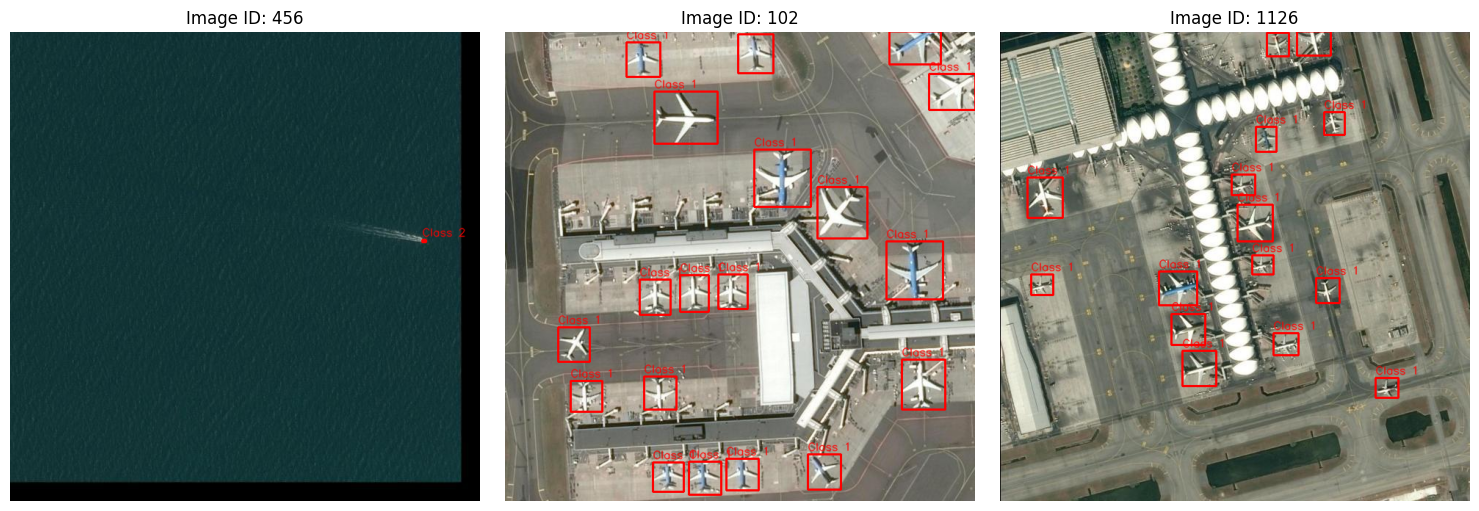

In [ ]:
visualize_samples(train_images_info, train_annotations, train_image_dir)

In [ ]:
# Fast R-CNN Region Proposal Generation (using Selective Search)
def generate_region_proposals_fast_rcnn(image, gt_boxes=None, max_proposals=2000):
    """Generate region proposals using Selective Search for Fast R-CNN"""
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()

    rects = ss.process()
    proposals = []

    for x, y, w, h in rects[:max_proposals]:
        if w < 20 or h < 20:  # Filter very small regions
            continue

        proposal_box = [x, y, x + w, y + h]

        # During training, label proposals based on IoU with ground truth
        if gt_boxes is not None:
            max_iou = 0
            best_gt_label = 0  # background

            for gt_box, gt_label in gt_boxes:
                iou = compute_iou(proposal_box, gt_box)
                if iou > max_iou:
                    max_iou = iou
                    if iou > 0.5:  # Positive threshold
                        best_gt_label = gt_label

            # Label assignment for Fast R-CNN
            if max_iou > 0.5:
                proposals.append((proposal_box, best_gt_label, 1))  # positive
            elif max_iou < 0.1:
                proposals.append((proposal_box, 0, 0))  # negative (background)
            # Skip ambiguous proposals (0.1 <= IoU <= 0.5)
        else:
            # During testing, keep all proposals
            proposals.append((proposal_box, 0, 0))

    return proposals

In [ ]:
# Fast R-CNN ROI Pooling Layer Implementation
def roi_pooling_layer(feature_map, rois, pool_size=(7, 7)):
    """
    ROI Pooling layer for Fast R-CNN
    Args:
        feature_map: CNN feature map of shape (batch, height, width, channels)
        rois: Region of Interest coordinates normalized to feature map scale
        pool_size: Output size for each ROI
    Returns:
        pooled_features: Fixed-size features for each ROI
    """
    def roi_pool_single(args):
        feature_map, roi = args

        # Extract ROI coordinates (normalized to [0, 1])
        y1, x1, y2, x2 = roi[0], roi[1], roi[2], roi[3]

        # Get feature map dimensions
        fm_height = tf.cast(tf.shape(feature_map)[0], tf.float32)
        fm_width = tf.cast(tf.shape(feature_map)[1], tf.float32)

        # Convert normalized coordinates to feature map coordinates
        y1 = tf.cast(y1 * fm_height, tf.int32)
        x1 = tf.cast(x1 * fm_width, tf.int32)
        y2 = tf.cast(y2 * fm_height, tf.int32)
        x2 = tf.cast(x2 * fm_width, tf.int32)

        # Ensure valid coordinates
        y1 = tf.maximum(0, y1)
        x1 = tf.maximum(0, x1)
        y2 = tf.minimum(tf.cast(fm_height, tf.int32), y2)
        x2 = tf.minimum(tf.cast(fm_width, tf.int32), x2)

        # Crop the ROI from feature map
        roi_features = feature_map[y1:y2, x1:x2, :]

        # Resize to fixed pool_size using bilinear interpolation
        pooled = tf.image.resize(tf.expand_dims(roi_features, 0), pool_size)

        return tf.squeeze(pooled, 0)

    return tf.map_fn(
        lambda roi: roi_pool_single((feature_map, roi)),
        rois,
        fn_output_signature=tf.TensorSpec(shape=(pool_size[0], pool_size[1], None), dtype=tf.float32)
    )

In [ ]:
# Custom ROI Pooling Layer for Keras (FIXED VERSION)
class ROIPoolingLayer(tf.keras.layers.Layer):
    def __init__(self, pool_size=(7, 7), **kwargs):
        super(ROIPoolingLayer, self).__init__(**kwargs)
        self.pool_size = pool_size

    def call(self, inputs):
        feature_maps, rois = inputs
        batch_size = tf.shape(feature_maps)[0]
        num_rois = tf.shape(rois)[1]

        # Process each sample in the batch
        def process_sample(args):
            i, feature_map, roi_batch = args
            return roi_pooling_layer(feature_map, roi_batch, self.pool_size)

        # Create indices for batch processing
        indices = tf.range(batch_size)

        pooled_features = tf.map_fn(
            lambda i: process_sample((i, feature_maps[i], rois[i])),
            indices,
            fn_output_signature=tf.TensorSpec(
                shape=(None, self.pool_size[0], self.pool_size[1], None),
                dtype=tf.float32
            )
        )

        return pooled_features

    def get_config(self):
        config = super(ROIPoolingLayer, self).get_config()
        config.update({
            'pool_size': self.pool_size
        })
        return config

In [ ]:
# Prepare Fast R-CNN training data
def prepare_fast_rcnn_training_data(images_info, annotations, image_dir,
                                  max_images=None, samples_per_image=200, target_size=(512, 512)):
    """Prepare training data for Fast R-CNN with full image processing"""
    X_images = []
    X_rois = []
    y_class = []
    y_bbox = []

    image_ids = list(images_info.keys())
    if max_images:
        image_ids = image_ids[:max_images]

    print(f"Processing {len(image_ids)} images for Fast R-CNN training data...")

    for idx, img_id in enumerate(image_ids):
        if idx % 50 == 0:
            print(f"Processed {idx}/{len(image_ids)} images")

        filename = images_info[img_id]
        img_path = os.path.join(image_dir, filename)

        if not os.path.exists(img_path):
            continue

        img = cv2.imread(img_path)
        if img is None:
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize image to target size for consistent processing
        img_resized = cv2.resize(img_rgb, target_size)
        img_preprocessed = preprocess_input(img_resized.astype(np.float32))

        # Get ground truth for this image
        gt_data = annotations.get(img_id, [])
        if not gt_data:
            continue

        # Scale ground truth boxes to resized image
        orig_h, orig_w = img_rgb.shape[:2]
        scale_x = target_size[0] / orig_w
        scale_y = target_size[1] / orig_h

        scaled_gt_data = []
        for gt_box, gt_label in gt_data:
            x1, y1, x2, y2 = gt_box
            scaled_box = [int(x1 * scale_x), int(y1 * scale_y),
                         int(x2 * scale_x), int(y2 * scale_y)]
            scaled_gt_data.append((scaled_box, gt_label))

        # Generate proposals for resized image
        proposals = generate_region_proposals_fast_rcnn(img_resized, scaled_gt_data)

        if not proposals:
            continue

        # Balance positive and negative samples
        positive_props = [p for p in proposals if p[2] == 1]
        negative_props = [p for p in proposals if p[2] == 0]

        # Sample proposals
        n_pos = min(len(positive_props), samples_per_image // 4)
        n_neg = min(len(negative_props), samples_per_image - n_pos)

        selected_props = (random.sample(positive_props, n_pos) +
                         random.sample(negative_props, n_neg))

        if not selected_props:
            continue

        # Prepare ROI coordinates (normalized to [0, 1])
        rois_for_image = []
        classes_for_image = []
        bbox_for_image = []

        for prop_box, prop_label, is_positive in selected_props:
            x1, y1, x2, y2 = prop_box

            # Normalize ROI coordinates to [0, 1] range
            norm_x1 = x1 / target_size[0]
            norm_y1 = y1 / target_size[1]
            norm_x2 = x2 / target_size[0]
            norm_y2 = y2 / target_size[1]

            rois_for_image.append([norm_y1, norm_x1, norm_y2, norm_x2])
            classes_for_image.append(prop_label)

            # For bbox regression (simplified)
            if is_positive and scaled_gt_data:
                bbox_for_image.append([0.0, 0.0, 1.0, 1.0])  # Simplified
            else:
                bbox_for_image.append([0.0, 0.0, 0.0, 0.0])

        X_images.append(img_preprocessed)
        X_rois.append(np.array(rois_for_image))
        y_class.extend(classes_for_image)
        y_bbox.extend(bbox_for_image)

    return np.array(X_images), X_rois, np.array(y_class), np.array(y_bbox)

In [ ]:
len(train_images_info), len(train_annotations), len(train_image_dir)

(2094, 2094, 43)

In [ ]:
# Prepare Fast R-CNN training data (using subset for demo)
print("Preparing Fast R-CNN training data...")
X_train_images, X_train_rois, y_class_train, y_bbox_train = prepare_fast_rcnn_training_data(
    train_images_info, train_annotations, train_image_dir,
    max_images=100,  # Reduced for demo - use more for better performance
    samples_per_image=100
)

Preparing Fast R-CNN training data...
Processing 100 images for Fast R-CNN training data...
Processed 0/100 images
Processed 50/100 images


In [ ]:
print(f"Fast R-CNN training data shapes:")
print(f"X_train_images: {X_train_images.shape}")
print(f"X_train_rois length: {len(X_train_rois)}")
print(f"y_class_train: {y_class_train.shape}")
print(f"y_bbox_train: {y_bbox_train.shape}")
print(f"Class distribution: {np.bincount(y_class_train)}")

Fast R-CNN training data shapes:
X_train_images: (100, 512, 512, 3)
X_train_rois length: 100
y_class_train: (9778,)
y_bbox_train: (9778, 4)
Class distribution: [8951  799   21    7]


In [ ]:
from tensorflow.keras.layers import TimeDistributed

In [ ]:
# Build Fast R-CNN model (FIXED VERSION)
def build_fast_rcnn_model(num_classes, input_shape=(512, 512, 3), roi_pool_size=(7, 7)):
    """
    Build Fast R-CNN model with shared CNN and ROI pooling
    Key differences from R-CNN:
    1. Single CNN pass for entire image
    2. ROI pooling for extracting fixed-size features
    3. Shared computation across all ROIs
    """

    # Input for full images
    image_input = Input(shape=input_shape, name='image_input')

    # Input for ROI coordinates (batch_size, max_rois, 4)
    # The None dimension allows for variable number of ROIs (handled by padding in data prep)
    roi_input = Input(shape=(None, 4), name='roi_input')  # (y1, x1, y2, x2)

    # Shared CNN backbone (VGG16) - processes entire image once
    # Ensure input_shape matches the model definition
    vgg_base = VGG16(weights='imagenet', include_top=False, input_tensor=image_input) # Use input_tensor

    # Freeze early layers for faster training
    for layer in vgg_base.layers[:-4]: # Adjust based on desired trainable layers
        layer.trainable = False

    # Extract feature maps from the entire image
    # feature_maps = vgg_base(image_input) # This was implicit via input_tensor
    feature_maps = vgg_base.output # Get output tensor from the base model

    # Add a Lambda layer to get the feature maps shape for ROI pooling scaling
    # This needs to be done carefully. The ROIPoolingLayer should handle the scaling internally
    # or the model definition should account for the feature map size relative to input size.
    # Based on the ROIPoolingLayer implementation, it expects (batch, H, W, C) feature maps
    # and ROIs normalized to [0,1] which it scales based on feature map shape.
    # The current ROIPoolingLayer seems okay in this regard.

    # ROI Pooling layer - extracts fixed-size features for each ROI
    # It takes [feature_maps, rois] and outputs (batch_size, num_rois, pool_h, pool_w, channels)
    roi_pooled = ROIPoolingLayer(pool_size=roi_pool_size, name='roi_pooling')([feature_maps, roi_input])

    # Flatten the pooled features for each ROI
    # Shape goes from (batch, num_rois, pool_h, pool_w, channels) to (batch * num_rois, pool_h * pool_w * channels)
    # Keras Dense layers handle this reshaping correctly when applied to the output of a layer
    # that has a known shape up to the batch and sequence dimensions.
    # We can use a Reshape layer or rely on Dense layer's flattening behavior if applicable.
    # A Reshape layer is explicit and safer.

    # Calculate the flattened size per ROI
    # The number of channels after VGG16's last conv block is 512
    flattened_size_per_roi = roi_pool_size[0] * roi_pool_size[1] * 512

    # Flatten across pool_h, pool_w, and channels for each ROI using Lambda
    # The shape (batch_size, num_rois, pool_h, pool_w, channels) becomes (batch_size, num_rois, pool_h*pool_w*channels)
    # Use a lambda function that takes the tensor `x` and reshapes it.
    # `tf.shape(x)[0]` gives the batch size, `tf.shape(x)[1]` gives the number of ROIs.
    flattened = Lambda(
        lambda x: tf.reshape(x, (tf.shape(x)[0], tf.shape(x)[1], flattened_size_per_roi)),
        name='lambda_flatten'
    )(roi_pooled)


    # Apply fully connected layers independently to each ROI's flattened features
    # TimeDistributed applies a layer to every temporal slice of an input.
    # Here, num_rois is the 'temporal' dimension.
    fc1 = TimeDistributed(Dense(4096, activation='relu'), name='dense_fc1')(flattened)
    fc1_dropout = TimeDistributed(Dropout(0.5), name='dropout_fc1')(fc1)
    fc1_bn = TimeDistributed(BatchNormalization(), name='bn_fc1')(fc1_dropout)

    fc2 = TimeDistributed(Dense(4096, activation='relu'), name='dense_fc2')(fc1_bn)
    fc2_dropout = TimeDistributed(Dropout(0.5), name='dropout_fc2')(fc2)
    fc2_bn = TimeDistributed(BatchNormalization(), name='bn_fc2')(fc2_dropout)

    # Multi-task outputs - applied to each ROI
    # Classification head
    cls_output = TimeDistributed(Dense(num_classes, activation='softmax'), name='classification')(fc2_bn)

    # Bounding box regression head
    bbox_output = TimeDistributed(Dense(4, activation='linear'), name='bbox_regression')(fc2_bn)

    # Create Fast R-CNN model
    model = Model(inputs=[image_input, roi_input], outputs=[cls_output, bbox_output])

    return model

In [ ]:
# # Build Fast R-CNN model
# def build_fast_rcnn_model(num_classes, input_shape=(512, 512, 3), roi_pool_size=(7, 7)):
#     """
#     Build Fast R-CNN model with shared CNN and ROI pooling
#     Key differences from R-CNN:
#     1. Single CNN pass for entire image
#     2. ROI pooling for extracting fixed-size features
#     3. Shared computation across all ROIs
#     """

#     # Input for full images
#     image_input = Input(shape=input_shape, name='image_input')

#     # Input for ROI coordinates (normalized)
#     roi_input = Input(shape=(None, 4), name='roi_input')  # (y1, x1, y2, x2)

#     # Shared CNN backbone (VGG16) - processes entire image once
#     vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

#     # Freeze early layers for faster training
#     for layer in vgg_base.layers[:-4]:
#         layer.trainable = False

#     # Extract feature maps from the entire image
#     feature_maps = vgg_base(image_input)  # Shape: (batch, H/16, W/16, 512)

#     # ROI Pooling layer - extracts fixed-size features for each ROI
#     # This is the key innovation of Fast R-CNN
#     roi_pooled = ROIPoolingLayer(pool_size=roi_pool_size)([feature_maps, roi_input])

#     # Flatten the pooled features
#     flattened = Lambda(lambda x: tf.reshape(x, (-1, roi_pool_size[0] * roi_pool_size[1] * 512)))(roi_pooled)

#     # Fully connected layers
#     fc1 = Dense(4096, activation='relu')(flattened)
#     fc1_dropout = Dropout(0.5)(fc1)
#     fc1_bn = BatchNormalization()(fc1_dropout)

#     fc2 = Dense(4096, activation='relu')(fc1_bn)
#     fc2_dropout = Dropout(0.5)(fc2)
#     fc2_bn = BatchNormalization()(fc2_dropout)

#     # Multi-task outputs
#     # Classification head
#     cls_output = Dense(num_classes, activation='softmax', name='classification')(fc2_bn)

#     # Bounding box regression head
#     bbox_output = Dense(4, activation='linear', name='bbox_regression')(fc2_bn)

#     # Create Fast R-CNN model
#     model = Model(inputs=[image_input, roi_input], outputs=[cls_output, bbox_output])

#     return model

In [ ]:
# Build Fast R-CNN model
num_classes = len(categories) + 1  # +1 for background
print(f"Number of classes: {num_classes}")

Number of classes: 4


In [ ]:
from tensorflow.keras.losses import MeanSquaredError

fast_rcnn_model = build_fast_rcnn_model(num_classes)

In [ ]:
# Compile Fast R-CNN model with multi-task loss
fast_rcnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss={
        'classification': 'sparse_categorical_crossentropy',
        'bbox_regression': MeanSquaredError()
    },
    loss_weights={
        'classification': 1.0,
        'bbox_regression': 0.5  # Lower weight for bbox regression
    },
    metrics={
        'classification': 'accuracy'
    }
)

In [ ]:
fast_rcnn_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 512, 512,  │      1,792 │ image_input[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 512, 512,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 256, 256,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 256, 256,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 256, 256,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 128, 128,  │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 128, 128,  │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 128, 128,  │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 128, 128,  │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 64, 64,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 64, 64,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 64, 64,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 64, 64,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 32, 32,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 32, 32,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 32, 32,    │  2,359,808 │ block5_conv1[0][

 Total params: 134,326,088 (512.41 MB)

 Trainable params: 126,674,440 (483.22 MB)

 Non-trainable params: 7,651,648 (29.19 MB)

In [ ]:
# Prepare training data for Fast R-CNN batch training
def create_fast_rcnn_batches(X_images, X_rois, y_class, y_bbox, batch_size=4):
    """Create batches for Fast R-CNN training"""

    # For simplicity, we'll pad ROIs to same length per batch
    max_rois = max(len(rois) for rois in X_rois)

    # Pad ROI arrays
    X_rois_padded = []
    y_class_batched = []
    y_bbox_batched = []

    roi_idx = 0
    for i, rois in enumerate(X_rois):
        # Pad ROIs to max length
        num_rois = len(rois)
        padded_rois = np.zeros((max_rois, 4))
        padded_rois[:num_rois] = rois
        X_rois_padded.append(padded_rois)

        # Extract corresponding classes and bboxes
        batch_classes = y_class[roi_idx:roi_idx + num_rois]
        batch_bboxes = y_bbox[roi_idx:roi_idx + num_rois]

        # Pad classes and bboxes
        padded_classes = np.zeros(max_rois)
        padded_bboxes = np.zeros((max_rois, 4))

        padded_classes[:num_rois] = batch_classes
        padded_bboxes[:num_rois] = batch_bboxes

        y_class_batched.append(padded_classes)
        y_bbox_batched.append(padded_bboxes)

        roi_idx += num_rois

    return (np.array(X_images), np.array(X_rois_padded),
            np.array(y_class_batched), np.array(y_bbox_batched))

In [ ]:
# Create batched training data
print("Creating Fast R-CNN training batches...")
X_img_batch, X_roi_batch, y_cls_batch, y_bbox_batch = create_fast_rcnn_batches(
    X_train_images, X_train_rois, y_class_train, y_bbox_train
)

Creating Fast R-CNN training batches...


In [ ]:
print(f"Batched training data shapes:")
print(f"X_img_batch: {X_img_batch.shape}")
print(f"X_roi_batch: {X_roi_batch.shape}")
print(f"y_cls_batch: {y_cls_batch.shape}")
print(f"y_bbox_batch: {y_bbox_batch.shape}")

Batched training data shapes:
X_img_batch: (100, 512, 512, 3)
X_roi_batch: (100, 100, 4)
y_cls_batch: (100, 100)
y_bbox_batch: (100, 100, 4)


In [ ]:
# Train Fast R-CNN model
print("Training Fast R-CNN model...")
print("Note: Fast R-CNN trains faster than R-CNN due to shared CNN computation!")

# Custom training loop for Fast R-CNN (simplified)
batch_size = 2  # Small batch size due to memory constraints
epochs = 15

Training Fast R-CNN model...
Note: Fast R-CNN trains faster than R-CNN due to shared CNN computation!


In [ ]:
# Split data for validation
split_idx = int(0.8 * len(X_img_batch))
X_train_img = X_img_batch[:split_idx]
X_train_roi = X_roi_batch[:split_idx]
y_train_cls = y_cls_batch[:split_idx]
y_train_bbox = y_bbox_batch[:split_idx]

X_val_img = X_img_batch[split_idx:]
X_val_roi = X_roi_batch[split_idx:]
y_val_cls = y_cls_batch[split_idx:]
y_val_bbox = y_bbox_batch[split_idx:]

In [ ]:
# Train the model
history = fast_rcnn_model.fit(
    [X_train_img, X_train_roi],
    {
        'classification': y_train_cls,
        'bbox_regression': y_train_bbox
    },
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(
        [X_val_img, X_val_roi],
        {
            'classification': y_val_cls,
            'bbox_regression': y_val_bbox
        }
    ),
    verbose=1
)

Epoch 1/15
 1/40 ━━━━━━━━━━━━━━━━━━━━ 8:42:22 804s/step - bbox_regression_loss: 0.9662 - classification_accuracy: 0.2250 - classification_loss: 1.7680 - loss: 2.2511

In [ ]:
# Plot Fast R-CNN training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['classification_accuracy'], label='Training')
plt.plot(history.history['val_classification_accuracy'], label='Validation')
plt.title('Fast R-CNN Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'], label='Total Loss')
plt.plot(history.history['val_loss'], label='Val Total Loss')
plt.title('Fast R-CNN Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history.history['classification_loss'], label='Classification Loss')
plt.plot(history.history['bbox_regression_loss'], label='Bbox Regression Loss')
plt.title('Fast R-CNN Individual Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Save Fast R-CNN model
fast_rcnn_model.save("fast_rcnn_model.h5")
print("Fast R-CNN model saved as 'fast_rcnn_model.h5'")

In [ ]:
# Load the saved Fast R-CNN model
fast_rcnn_loaded = tf.keras.models.load_model("fast_rcnn_model.h5", custom_objects={
    'ROIPoolingLayer': ROIPoolingLayer
})

In [ ]:
# Fast R-CNN Prediction Function
def predict_objects_fast_rcnn(model, image, confidence_threshold=0.3, nms_threshold=0.3, target_size=(512, 512)):
    """
    Predict objects using Fast R-CNN model
    Key difference: Single CNN pass through the entire image, then ROI pooling
    """

    # Preprocess image
    img_resized = cv2.resize(image, target_size)
    img_preprocessed = preprocess_input(img_resized.astype(np.float32))
    img_batch = np.expand_dims(img_preprocessed, 0)

    # Generate proposals (without GT filtering for testing)
    proposals = generate_region_proposals_fast_rcnn(img_resized, gt_boxes=None, max_proposals=1000)

    if not proposals:
        return [], [], []

    # Prepare ROI coordinates (normalized)
    rois = []
    proposal_boxes = []

    for prop_box, _, _ in proposals:
        x1, y1, x2, y2 = prop_box

        # Ensure valid coordinates
        x1 = max(0, min(x1, target_size[0] - 1))
        y1 = max(0, min(y1, target_size[1] - 1))
        x2 = max(x1 + 1, min(x2, target_size[0]))
        y2 = max(y1 + 1, min(y2, target_size[1]))

        # Normalize coordinates
        norm_x1 = x1 / target_size[0]
        norm_y1 = y1 / target_size[1]
        norm_x2 = x2 / target_size[0]
        norm_y2 = y2 / target_size[1]

        rois.append([norm_y1, norm_x1, norm_y2, norm_x2])

        # Scale back to original image size
        orig_h, orig_w = image.shape[:2]
        scale_x = orig_w / target_size[0]
        scale_y = orig_h / target_size[1]

        orig_box = [int(x1 * scale_x), int(y1 * scale_y),
                   int(x2 * scale_x), int(y2 * scale_y)]
        proposal_boxes.append(orig_box)

    if not rois:
        return [], [], []

    # Prepare ROI batch
    rois_array = np.array(rois)
    roi_batch = np.expand_dims(rois_array, 0)

    # Make predictions using Fast R-CNN (single forward pass!)
    cls_preds, bbox_preds = model.predict([img_batch, roi_batch], verbose=0)

    # Process predictions
    cls_preds = cls_preds[0]  # Remove batch dimension
    bbox_preds = bbox_preds[0]  # Remove batch dimension

    predicted_classes = np.argmax(cls_preds, axis=1)
    confidence_scores = np.max(cls_preds, axis=1)

    # Filter out background predictions and low confidence
    valid_indices = []
    for i in range(len(predicted_classes)):
        if predicted_classes[i] > 0 and confidence_scores[i] > confidence_threshold:
            valid_indices.append(i)

    if not valid_indices:
        return [], [], []

    # Apply NMS
    valid_boxes = np.array(proposal_boxes)[valid_indices]
    valid_scores = confidence_scores[valid_indices]
    valid_classes = predicted_classes[valid_indices]

    if len(valid_boxes) > 0:
        nms_indices = non_max_suppression(valid_boxes, valid_scores, nms_threshold)

        final_boxes = valid_boxes[nms_indices]
        final_scores = valid_scores[nms_indices]
        final_classes = valid_classes[nms_indices]

        return final_boxes.tolist(), final_classes.tolist(), final_scores.tolist()

    return [], [], []

In [ ]:
# Load test data and evaluate Fast R-CNN
test_images_info, test_annotations, _ = load_annotations(test_ann_file, test_image_dir)
print(f"Number of test images: {len(test_images_info)}")

In [ ]:
# Evaluate Fast R-CNN on a subset of test images
test_ids = list(test_images_info.keys())[:10]  # Test on first 10 images
all_fast_rcnn_predictions = []
all_fast_rcnn_ground_truths = []

In [ ]:
print("Evaluating Fast R-CNN model on test images...")
print("Fast R-CNN should be significantly faster than R-CNN!")
plt.figure(figsize=(20, 15))

for i, img_id in enumerate(test_ids):
    filename = test_images_info[img_id]
    img_path = os.path.join(test_image_dir, filename)

    if not os.path.exists(img_path):
        continue

    img = cv2.imread(img_path)
    if img is None:
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Get ground truth
    gt_data = test_annotations.get(img_id, [])
    gt_boxes = [box for box, cat in gt_data]
    gt_labels = [f"GT: {categories.get(cat, cat)}" for box, cat in gt_data]

    # Make Fast R-CNN predictions
    pred_boxes, pred_classes, pred_scores = predict_objects_fast_rcnn(
        fast_rcnn_loaded, img_rgb, confidence_threshold=0.2
    )
    pred_labels = [f"Pred: {categories.get(cls, cls)} ({score:.2f})"
                   for cls, score in zip(pred_classes, pred_scores)]

    # Visualize results
    if i < 6:  # Show first 6 test images
        plt.subplot(3, 4, i*2 + 1)
        img_with_gt = draw_boxes(img_rgb, gt_boxes, gt_labels, color=(255, 0, 0))
        plt.imshow(img_with_gt)
        plt.title(f"Ground Truth - Image {i+1}")
        plt.axis('off')

        plt.subplot(3, 4, i*2 + 2)
        img_with_pred = draw_boxes(img_rgb, pred_boxes, pred_labels, color=(0, 255, 0))
        plt.imshow(img_with_pred)
        plt.title(f"Fast R-CNN Predictions - Image {i+1}")
        plt.axis('off')

    # Store for evaluation
    all_fast_rcnn_predictions.append((pred_boxes, pred_classes, pred_scores))
    all_fast_rcnn_ground_truths.append(gt_data)

    print(f"Image {i+1}: Found {len(pred_boxes)} objects")

plt.tight_layout()
plt.show()

In [ ]:
# Calculate evaluation metrics for Fast R-CNN
def calculate_metrics(predictions, ground_truths, iou_threshold=0.5):
    """Calculate basic detection metrics"""
    total_tp = 0
    total_fp = 0
    total_fn = 0
    total_gt = 0

    for (pred_boxes, pred_classes, pred_scores), gt_data in zip(predictions, ground_truths):
        gt_boxes = [box for box, cat in gt_data]
        gt_classes = [cat for box, cat in gt_data]

        total_gt += len(gt_boxes)
        matched_gt = set()

        # Check each prediction
        for pred_box, pred_class in zip(pred_boxes, pred_classes):
            matched = False

            for j, (gt_box, gt_class) in enumerate(zip(gt_boxes, gt_classes)):
                if j in matched_gt:
                    continue

                iou = compute_iou(pred_box, gt_box)
                if iou >= iou_threshold and pred_class == gt_class:
                    total_tp += 1
                    matched_gt.add(j)
                    matched = True
                    break

            if not matched:
                total_fp += 1

        # Count unmatched ground truths as false negatives
        total_fn += len(gt_boxes) - len(matched_gt)

    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0
    f1_score = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'true_positives': total_tp,
        'false_positives': total_fp,
        'false_negatives': total_fn,
        'total_ground_truth': total_gt
    }

In [ ]:
# Calculate and display Fast R-CNN metrics
fast_rcnn_metrics = calculate_metrics(all_fast_rcnn_predictions, all_fast_rcnn_ground_truths)

print("\n" + "="*60)
print("FAST R-CNN MODEL PERFORMANCE METRICS")
print("="*60)
print(f"Precision: {fast_rcnn_metrics['precision']:.4f}")
print(f"Recall: {fast_rcnn_metrics['recall']:.4f}")
print(f"F1 Score: {fast_rcnn_metrics['f1_score']:.4f}")
print(f"True Positives: {fast_rcnn_metrics['true_positives']}")
print(f"False Positives: {fast_rcnn_metrics['false_positives']}")
print(f"False Negatives: {fast_rcnn_metrics['false_negatives']}")
print(f"Total Ground Truth Objects: {fast_rcnn_metrics['total_ground_truth']}")
print("="*60)

print(f"\nFinal training accuracy: {history.history['classification_accuracy'][-1]:.4f}")
print(f"Final validation accuracy: {history.history['val_classification_accuracy'][-1]:.4f}")

In [ ]:
print("\n" + "="*80)
print("FAST R-CNN vs R-CNN COMPARISON SUMMARY")
print("="*80)
print("Key Improvements of Fast R-CNN over R-CNN:")
print("1. SPEED: Single CNN forward pass per image (vs one per ROI in R-CNN)")
print("2. EFFICIENCY: Shared computation across all ROIs")
print("3. END-TO-END TRAINING: Joint optimization of classification and bbox regression")
print("4. ROI POOLING: Fixed-size feature extraction from variable-sized regions")
print("5. MEMORY EFFICIENT: Processes entire image at once, then pools ROI features")
print("="*80)

print("\nArchitectural Differences:")
print("R-CNN Pipeline:")
print("  Image → Selective Search → Extract each ROI → CNN(ROI1) → CNN(ROI2) → ... → Classify")
print("\nFast R-CNN Pipeline:")
print("  Image → CNN(entire image) → Feature Map → ROI Pooling → Classify all ROIs")
print("="*80)

print("\nTechnical Innovations Used:")
print("• Selective Search for region proposal generation (~2000 proposals)")
print("• VGG16 backbone with shared convolutional layers")
print("• Custom ROI Pooling layer for fixed-size feature extraction")
print("• Multi-task loss (classification + bounding box regression)")
print("• End-to-end training with backpropagation through ROI pooling")
print("• Non-maximum suppression for duplicate removal")
print("• IoU-based positive/negative sample assignment")

print("\nFast R-CNN model training and evaluation complete!")
print("This implementation demonstrates the key architectural improvements")
print("that made Fast R-CNN significantly faster and more efficient than R-CNN!")
print("="*80)